#### Causal Discovery Module Research

In [17]:
# !pip install wget

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9680 sha256=aaa7a419e6823aa12e8a3f0bcaaaf4ab9b6f0026b498164c537dcaf0ed7b9763
  Stored in directory: c:\users\tomle\appdata\local\pip\cache\wheels\8b\f1\7f\5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [1]:
#Causal Graph Viz for slide
import warnings
warnings.filterwarnings('ignore')

from IPython.display import Markdown
import wget
import pandas as pd
import numpy as np
import graphviz as gr
from matplotlib import style
import seaborn as sns
from matplotlib import pyplot as plt
style.use("fivethirtyeight")

import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

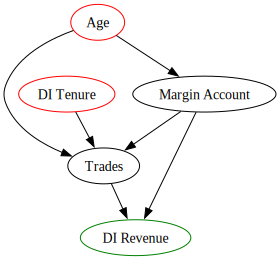

In [2]:
#DI Example
g = gr.Digraph()

g.edge("Margin Account", "Trades")
g.edge("Trades", "DI Revenue")
g.edge("Margin Account", "DI Revenue")
g.edge("Age", "Margin Account")
g.edge("Age", "Trades")
g.edge("DI Tenure", "Trades")

g.node("DI Revenue", "DI Revenue", color="green")
g.node("Age", "Age", color="red")
g.node("DI Tenure", "DI Tenure", color="red")

g

In [3]:
#Example dataset - 1991 Survey of Income and Program Participation (401k)
file = "https://raw.githubusercontent.com/CausalAIBook/MetricsMLNotebooks/main/data/401k.csv"
data = pd.read_csv(file)
data.head()

,ira,a401,hval,hmort,hequity,nifa,net_nifa,tfa,net_tfa,tfa_he,...,i3,i4,i5,i6,i7,a1,a2,a3,a4,a5
0,0,0,69000,60150,8850,100,-3300,100,-3300,5550,...,1,0,0,0,0,0,1,0,0,0
1,0,0,78000,20000,58000,61010,61010,61010,61010,119010,...,0,1,0,0,0,0,0,0,1,0
2,1800,0,200000,15900,184100,7549,7049,9349,8849,192949,...,0,0,0,1,0,0,0,0,1,0
3,0,0,0,0,0,2487,-6013,2487,-6013,-6013,...,0,0,1,0,0,1,0,0,0,0
4,0,0,300000,90000,210000,10625,-2375,10625,-2375,207625,...,0,1,0,0,0,0,0,1,0,0


In [77]:
# #401k dataset metadata
# # readme = "https://raw.githubusercontent.com/CausalAIBook/MetricsMLNotebooks/main/data/401k.md"
# # filename = wget.download(readme)
# Markdown(open('401k.md', 'r').read())

In [5]:
# import dagma
# print(dagma.__file__)

In [64]:
#NonLinear_CausalDiscovery Testing

#this module will contain the main classes for causal discovery and DAG visualization

import pandas as pd
import numpy as np
import torch
from dagma import utils
# from dagma.linear import DagmaLinear
from dagma.nonlinear import DagmaMLP, DagmaNonlinear
import graphviz as gr

class NonLinear_CausalDiscovery():

    """Main class for causal discovery (Non-linear). Instances of this class will learn a DAG from input data using a specified method. Instantiating this class will automatically learn a DAG from the input data using the provided method.

    Linear class to be added later.

    Parameters
    ----------
    data : np.ndarray
        The input data containing X, T and Y as a NumPy array.
    method: str, optional
        Method used for causal discovery. Currently only supports the default algorithm ("dagma")
    col_names: list
        List of column names for the input data.

    """


    def __init__(self, data: np.ndarray, col_names=None ,method: str='dagma', dag=None,pruned_dag=None):
        self.data = data
        self.col_names = col_names
        self.method = method
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self._validate_data()
        self.dag = self.learn_dag()
        self.pruned_dag = None

    def _validate_data(self):
        if not isinstance(self.data, np.ndarray):
            raise ValueError('Input data must be a NumPy ndarray.')
        if not np.issubdtype(self.data.dtype, np.number):
            raise ValueError('Input data must be numeric.')
        if self.col_names is None:
            raise ValueError('List of column names not provided.')
        if len(self.col_names) != self.data.shape[1]:
            raise ValueError('Number of column names does not match number of columns in data.')

    def learn_dag(self):
        if self.method == 'dagma':
            # define MLP for structural equations with given dimensions [d, 2d, d, 1] and associated model
            d = self.data.shape[1]
            eq_model = DagmaMLP(dims=[d, int(d/2), 1], bias=True, dtype=torch.double).to(self.device)
            model = DagmaNonlinear(eq_model, dtype=torch.double)

            #Move data to GPU if available, otherwise use CPU
            data_tensor = torch.tensor(self.data, dtype=torch.double).to(self.device)

            # fit the model with default L1 and L2 regularization and no default minimum weight threshold
            W_est = model.fit(data_tensor, lambda1=0, lambda2=0, w_threshold=0)
            return W_est  # Move the result back to CPU and convert to NumPy array
        else:
            raise ValueError('Invalid method. Currently only supports "dagma".')
        
    def prune_dag(self, prune_method='percent', prune_threshold=0.05):
        if prune_method == 'percent':
            pruned_dag = np.where(self.dag <= self.dag.sum()*prune_threshold, 0, self.dag)
        if prune_method == 'absolute':
            pruned_dag = np.where(self.dag <= prune_threshold, 0, self.dag)
        return pruned_dag
    
    def display_dag(self, prune_method='percent', prune_threshold=0.05, return_pruned_W=False):
        if prune_method in ['percent', 'absolute']:
            adj_matrix = self.prune_dag(prune_method=prune_method, prune_threshold=prune_threshold)
        else:
            raise ValueError('Invalid pruning method. Supports either "percent" or "absolute".')

        dot = gr.Digraph()

        for i in range(adj_matrix.shape[0]):
            for j in range(adj_matrix.shape[1]):
                if adj_matrix[i,j] != 0:
                    weight = adj_matrix[i, j]
                    dot.edge(self.col_names[i], self.col_names[j], label=f'{weight:.2f}')

        if return_pruned_W:
            self.pruned_dag = adj_matrix
            return dot
        else:
            return dot
        
    

    

In [ ]:
# #with the built in ER graph simulation, weights range ~0.5-1, with the following sum. By default dagma Nonlinear uses a threshold of 0.3
# W_est.sum() ~= 18

In [66]:
#define inputs
# select_data = data[data.columns[:-12]]
select_data = data.loc[:, data.nunique() > 2]
col_names = select_data.columns

#use a small random sample of the data for testing
input_data = select_data.to_numpy()

input_data.shape

(9915, 19)

In [67]:
#instantiate NonLinear_CausalDiscovery
dagma_401k = NonLinear_CausalDiscovery(input_data, col_names=col_names)

100%|██████████| 230000/230000.0 [00:22<00:00, 10207.96it/s]


Is pruned graph a DAG (i.e. acyclic)? True


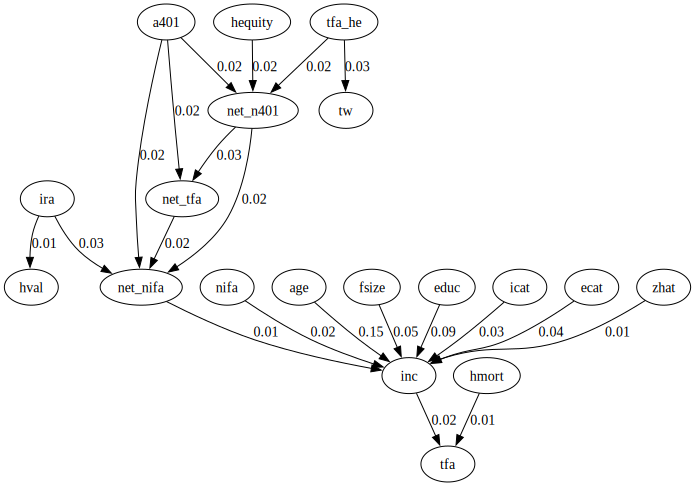

In [70]:
#display DAG
dot = dagma_401k.display_dag(prune_method='percent', prune_threshold=0.01,return_pruned_W=True)
print('Is pruned graph a DAG (i.e. acyclic)?', utils.is_dag(dagma_401k.pruned_dag))
dot

In [71]:
dagma_401k.dag.sum()

0.9567665358287432